# Import

In [1]:
!pip install imbalanced-learn
import imblearn
print(imblearn.__version__)

0.12.4


In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import seaborn as sns
import statistics
import math as m

# import necessary packages
import pandas as pd
from copy import deepcopy as copy
import numpy as np
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch import save as torch_save
from sklearn import datasets
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE
from collections import Counter
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.metrics import confusion_matrix

# MODEL CREATION
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# RNN: data set-up

## EDA

In [4]:
region = 9
data_dir = "/content/drive/MyDrive/MS thesis"
x = f"/content/drive/MyDrive/MS thesis/preliminary site selection/RG{region}/rg{region}_clusters.csv"
rg1n_clustered_df = pd.read_csv(x)
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster
0,0,3313430,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0.0,0,...,3330011,19.160349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
1,1,3314812,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0.0,0,...,3330011,16.402226,10.919576,19.932560,124.968488,62.917560,26.345644,21.145848,0.424699,0
2,2,3314813,Sila,San Vicente,Northern Samar,1.470177,1.547435,0.429685,0.0,0,...,3330011,17.733638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
3,3,3316193,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0.0,0,...,3330011,15.696258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
4,4,3316194,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0.0,0,...,3330011,15.889344,2.360123,4.308162,27.010301,13.598806,5.694266,4.570398,0.424699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,8981,3504237,Ngolos,Guiuan,Eastern Samar,3.142842,1.754262,0.584311,0.0,0,...,3460006,46.986907,0.984148,0.680468,7.912546,3.801621,1.782713,1.366559,0.392827,0
8982,8982,3505637,Cagusu-an,Guiuan,Eastern Samar,2.160672,1.754547,0.564089,0.0,0,...,3460006,62.553435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
8983,8983,3507003,Sulangan,Guiuan,Eastern Samar,3.232944,1.746120,0.587511,0.0,0,...,3460006,50.731541,118.603833,84.144597,999.317445,505.669059,212.364957,147.453414,0.461363,0
8984,8984,3518072,Suluan,Guiuan,Eastern Samar,2.965111,1.737982,0.569467,0.0,0,...,3460006,70.953292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0


## Balance data
- this is so the model is properly trained with a more distributed set of data with 0s and 1s.


1. Downsampling data: to remove unbuildable areas
2. Dataframe set up: normalizing data
3. Upsampling data: generate data points with '1' label (just to teach the model)
4. Get low accessible areas (to turn into Candidate Sites)


### Downsampling

In [5]:
print(rg1n_clustered_df.shape)
print(rg1n_clustered_df['RHU_Presence'].unique())
print(rg1n_clustered_df['Cluster'].unique())
buildable = rg1n_clustered_df[rg1n_clustered_df['RHU_Presence'] == 1]
buildable

(8986, 22)
[0 1]
[0 1]


,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster
36,36,3330011,Poblacion Barangay 2,Capul,Northern Samar,1.121741,1.461005,0.531970,0.0,1,...,3330011,0.0,125.622044,198.256795,1450.526487,746.770031,334.267201,255.273099,0.469500,0
298,298,3353597,Guiwan 1 (Pob.),Palompon,Leyte,1.474404,1.733066,0.855013,0.0,1,...,3353597,0.0,776.290804,842.036758,8030.162304,4063.355687,2070.823705,1539.804809,0.418218,0
729,729,3363171,Barangay North (Pob.),San Jose,Northern Samar,1.583639,1.795818,0.685848,0.0,1,...,3363171,0.0,195.716123,88.762457,1443.303291,698.825705,323.049642,259.419765,0.506698,0
1132,1132,3370082,Salvacion,Bobon,Northern Samar,1.553320,1.784341,0.734574,0.0,1,...,3370082,0.0,829.887023,538.350229,7443.771018,3797.620692,1787.976131,1438.971850,0.429498,0
1525,1525,3377093,Barangay 3 (Pob.),Ormoc City,Leyte,1.076424,1.840858,0.927464,0.0,1,...,3377093,0.0,2313.223762,1435.531282,21533.182405,10979.592565,5894.718151,4397.918610,0.438031,0
2086,2086,3389513,Tagak,Carigara,Leyte,1.535560,1.915587,0.884672,0.0,1,...,3389513,0.0,85.116350,51.098586,630.661872,300.752866,132.497106,114.322074,0.406445,0
2161,2161,3390853,Poblacion A,Tarangnan,Samar (Western Samar),0.065365,1.480702,0.731310,0.0,1,...,3390853,0.0,471.849389,352.277926,4083.122350,2056.833972,972.760521,812.259254,0.451359,0
2397,2397,3393720,Central Barangay (Pob.),Hilongos,Leyte,1.300219,1.759552,0.810862,0.0,1,...,3393720,0.0,763.282446,746.016315,7654.034764,3866.198599,1936.332666,1440.209168,0.493502,0
2628,2628,3396482,Tejero,Hilongos,Leyte,1.286644,1.756597,0.843330,0.0,1,...,3396482,0.0,60.369870,67.548540,616.521606,285.369936,125.008938,104.506170,0.418098,0
3132,3132,3401956,Holy Child I (Pob.),Alangalang,Leyte,1.607970,1.952581,1.081625,0.0,1,...,3401956,0.0,645.131505,568.580625,6554.743202,3242.917153,1654.611956,1333.839947,0.384767,0


In [6]:
# Drop rows with NaN values
rg1n_clustered_df.dropna(inplace=True) # DROP NANS so it doesnt interfere with the pcf calculations
rg1n_clustered_df['buildability_landcov'] = rg1n_clustered_df['buildability_landcov'].astype(int) # CONVERT LAND COV COL INTO INT FROM FLOAT
high_clustered = rg1n_clustered_df[rg1n_clustered_df['Cluster'] == 1]
high_clustered['buildability_landcov'].unique()
rg1n_clustered_df[rg1n_clustered_df['Cluster'] == 0]

''' If ever non buildable values come out for clusters with 1, change their values to buildable '''
# rg1n_clustered_df.loc[1079, ['buildability_landcov']] = [1]
# rg1n_clustered_df.loc[4676, ['buildability_landcov']] = [1]
# Filter rows with clusters of size 1
df_filtered = rg1n_clustered_df[rg1n_clustered_df['Cluster'] == 1]

if not df_filtered.empty:
    # Use loc[] for index-based updates
    df_filtered.loc[:, 'buildability_landcov'] = 1  # Update entire column with 1
    rg1n_clustered_df.update(df_filtered)
    print("Updated 'buildability_landcov' values to 1 for clusters with size 1.")
else:
    print("No clusters with size 1 found in the DataFrame.")
# print(rg1n_clustered_df)
rg1n_clustered_df

Updated 'buildability_landcov' values to 1 for clusters with size 1.


,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster
0,0,3313430,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,19.160349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
1,1,3314812,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,16.402226,10.919576,19.932560,124.968488,62.917560,26.345644,21.145848,0.424699,0
2,2,3314813,Sila,San Vicente,Northern Samar,1.470177,1.547435,0.429685,0,0,...,3330011,17.733638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
3,3,3316193,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,15.696258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
4,4,3316194,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,15.889344,2.360123,4.308162,27.010301,13.598806,5.694266,4.570398,0.424699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,8981,3504237,Ngolos,Guiuan,Eastern Samar,3.142842,1.754262,0.584311,0,0,...,3460006,46.986907,0.984148,0.680468,7.912546,3.801621,1.782713,1.366559,0.392827,0
8982,8982,3505637,Cagusu-an,Guiuan,Eastern Samar,2.160672,1.754547,0.564089,0,0,...,3460006,62.553435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
8983,8983,3507003,Sulangan,Guiuan,Eastern Samar,3.232944,1.746120,0.587511,0,0,...,3460006,50.731541,118.603833,84.144597,999.317445,505.669059,212.364957,147.453414,0.461363,0
8984,8984,3518072,Suluan,Guiuan,Eastern Samar,2.965111,1.737982,0.569467,0,0,...,3460006,70.953292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0


In [7]:
'''DROP NON-BUILDABLE AREAS
>> dont do this anymore
'''
non_buildable = rg1n_clustered_df[rg1n_clustered_df['buildability_landcov'] == 0]
# rg1n_clustered_df.drop(rg1n_clustered_df.index[rg1n_clustered_df['buildability_landcov'] == 0], inplace = True)
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster
0,0,3313430,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,19.160349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
1,1,3314812,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,16.402226,10.919576,19.932560,124.968488,62.917560,26.345644,21.145848,0.424699,0
2,2,3314813,Sila,San Vicente,Northern Samar,1.470177,1.547435,0.429685,0,0,...,3330011,17.733638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
3,3,3316193,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,15.696258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
4,4,3316194,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,15.889344,2.360123,4.308162,27.010301,13.598806,5.694266,4.570398,0.424699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,8981,3504237,Ngolos,Guiuan,Eastern Samar,3.142842,1.754262,0.584311,0,0,...,3460006,46.986907,0.984148,0.680468,7.912546,3.801621,1.782713,1.366559,0.392827,0
8982,8982,3505637,Cagusu-an,Guiuan,Eastern Samar,2.160672,1.754547,0.564089,0,0,...,3460006,62.553435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
8983,8983,3507003,Sulangan,Guiuan,Eastern Samar,3.232944,1.746120,0.587511,0,0,...,3460006,50.731541,118.603833,84.144597,999.317445,505.669059,212.364957,147.453414,0.461363,0
8984,8984,3518072,Suluan,Guiuan,Eastern Samar,2.965111,1.737982,0.569467,0,0,...,3460006,70.953292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0


In [8]:
print(rg1n_clustered_df)
print(non_buildable)
print(rg1n_clustered_df['RHU_Presence'].unique())
non_buildable

      Unnamed: 0       ID barangay_name    city_name   province_name  \
0              0  3313430       Maragat  San Vicente  Northern Samar   
1              1  3314812       Maragat  San Vicente  Northern Samar   
2              2  3314813          Sila  San Vicente  Northern Samar   
3              3  3316193       Maragat  San Vicente  Northern Samar   
4              4  3316194       Maragat  San Vicente  Northern Samar   
...          ...      ...           ...          ...             ...   
8981        8981  3504237        Ngolos       Guiuan   Eastern Samar   
8982        8982  3505637     Cagusu-an       Guiuan   Eastern Samar   
8983        8983  3507003      Sulangan       Guiuan   Eastern Samar   
8984        8984  3518072        Suluan       Guiuan   Eastern Samar   
8985        8985  3519454        Suluan       Guiuan   Eastern Samar   

      flood_probability_value  rain intensity_value  drought_value  \
0                    1.851208              1.533578       0.44834

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster
0,0,3313430,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,19.160349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
1,1,3314812,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,16.402226,10.919576,19.932560,124.968488,62.917560,26.345644,21.145848,0.424699,0
2,2,3314813,Sila,San Vicente,Northern Samar,1.470177,1.547435,0.429685,0,0,...,3330011,17.733638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
3,3,3316193,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,15.696258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
4,4,3316194,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,15.889344,2.360123,4.308162,27.010301,13.598806,5.694266,4.570398,0.424699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,8981,3504237,Ngolos,Guiuan,Eastern Samar,3.142842,1.754262,0.584311,0,0,...,3460006,46.986907,0.984148,0.680468,7.912546,3.801621,1.782713,1.366559,0.392827,0
8982,8982,3505637,Cagusu-an,Guiuan,Eastern Samar,2.160672,1.754547,0.564089,0,0,...,3460006,62.553435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
8983,8983,3507003,Sulangan,Guiuan,Eastern Samar,3.232944,1.746120,0.587511,0,0,...,3460006,50.731541,118.603833,84.144597,999.317445,505.669059,212.364957,147.453414,0.461363,0
8984,8984,3518072,Suluan,Guiuan,Eastern Samar,2.965111,1.737982,0.569467,0,0,...,3460006,70.953292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0


In [9]:
rg1n_clustered_df = rg1n_clustered_df.reset_index(drop=True)
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster
0,0,3313430,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,19.160349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
1,1,3314812,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,16.402226,10.919576,19.932560,124.968488,62.917560,26.345644,21.145848,0.424699,0
2,2,3314813,Sila,San Vicente,Northern Samar,1.470177,1.547435,0.429685,0,0,...,3330011,17.733638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
3,3,3316193,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,15.696258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
4,4,3316194,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,3330011,15.889344,2.360123,4.308162,27.010301,13.598806,5.694266,4.570398,0.424699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,8981,3504237,Ngolos,Guiuan,Eastern Samar,3.142842,1.754262,0.584311,0,0,...,3460006,46.986907,0.984148,0.680468,7.912546,3.801621,1.782713,1.366559,0.392827,0
8982,8982,3505637,Cagusu-an,Guiuan,Eastern Samar,2.160672,1.754547,0.564089,0,0,...,3460006,62.553435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
8983,8983,3507003,Sulangan,Guiuan,Eastern Samar,3.232944,1.746120,0.587511,0,0,...,3460006,50.731541,118.603833,84.144597,999.317445,505.669059,212.364957,147.453414,0.461363,0
8984,8984,3518072,Suluan,Guiuan,Eastern Samar,2.965111,1.737982,0.569467,0,0,...,3460006,70.953292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0


### DF Set-up
- Data is normalized

In [10]:
rg1n_clustered_df.columns

Index(['Unnamed: 0', 'ID', 'barangay_name', 'city_name', 'province_name',
       'flood_probability_value', 'rain intensity_value', 'drought_value',
       'buildability_landcov', 'RHU_Presence', 'Road_Presence', 'POI_Presence',
       'Nearest_RHU', 'Distance_to_Nearest_RHU_km', 'popden_chi', 'popden_eld',
       'popden_all', 'popden_wom', 'popden_w_1', 'popden_you', 'HCFAI',
       'Cluster'],
      dtype='object')

In [11]:
'''AGGREGATING THE POPULATION'''
# Assuming df is your DataFrame
vp =  rg1n_clustered_df['popden_chi'] + rg1n_clustered_df['popden_eld'] + rg1n_clustered_df['popden_wom'] + rg1n_clustered_df['popden_you'] + rg1n_clustered_df['popden_w_1'] + rg1n_clustered_df['popden_you']
gen = rg1n_clustered_df['popden_all'] - vp
all = vp + gen
rg1n_clustered_df['total_population'] = all
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster,total_population
0,0,3313430,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,19.160349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
1,1,3314812,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,16.402226,10.919576,19.932560,124.968488,62.917560,26.345644,21.145848,0.424699,0,124.968488
2,2,3314813,Sila,San Vicente,Northern Samar,1.470177,1.547435,0.429685,0,0,...,17.733638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
3,3,3316193,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,15.696258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
4,4,3316194,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,15.889344,2.360123,4.308162,27.010301,13.598806,5.694266,4.570398,0.424699,0,27.010301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,8981,3504237,Ngolos,Guiuan,Eastern Samar,3.142842,1.754262,0.584311,0,0,...,46.986907,0.984148,0.680468,7.912546,3.801621,1.782713,1.366559,0.392827,0,7.912546
8982,8982,3505637,Cagusu-an,Guiuan,Eastern Samar,2.160672,1.754547,0.564089,0,0,...,62.553435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
8983,8983,3507003,Sulangan,Guiuan,Eastern Samar,3.232944,1.746120,0.587511,0,0,...,50.731541,118.603833,84.144597,999.317445,505.669059,212.364957,147.453414,0.461363,0,999.317445
8984,8984,3518072,Suluan,Guiuan,Eastern Samar,2.965111,1.737982,0.569467,0,0,...,70.953292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000


In [12]:
rg1n_clustered_df.loc[rg1n_clustered_df['total_population'] == 0]
# Drop rows with NaN values
rg1n_clustered_df.dropna(inplace=True)
# x_normalized.dropna(inplace=True)

# Convert column 'x14' from float to int
rg1n_clustered_df['buildability_landcov'] = rg1n_clustered_df['buildability_landcov'].astype(int)
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster,total_population
0,0,3313430,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,19.160349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
1,1,3314812,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,16.402226,10.919576,19.932560,124.968488,62.917560,26.345644,21.145848,0.424699,0,124.968488
2,2,3314813,Sila,San Vicente,Northern Samar,1.470177,1.547435,0.429685,0,0,...,17.733638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
3,3,3316193,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,15.696258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
4,4,3316194,Maragat,San Vicente,Northern Samar,1.851208,1.533578,0.448349,0,0,...,15.889344,2.360123,4.308162,27.010301,13.598806,5.694266,4.570398,0.424699,0,27.010301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,8981,3504237,Ngolos,Guiuan,Eastern Samar,3.142842,1.754262,0.584311,0,0,...,46.986907,0.984148,0.680468,7.912546,3.801621,1.782713,1.366559,0.392827,0,7.912546
8982,8982,3505637,Cagusu-an,Guiuan,Eastern Samar,2.160672,1.754547,0.564089,0,0,...,62.553435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
8983,8983,3507003,Sulangan,Guiuan,Eastern Samar,3.232944,1.746120,0.587511,0,0,...,50.731541,118.603833,84.144597,999.317445,505.669059,212.364957,147.453414,0.461363,0,999.317445
8984,8984,3518072,Suluan,Guiuan,Eastern Samar,2.965111,1.737982,0.569467,0,0,...,70.953292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000


In [13]:
numeric_rg1_clustered_df = rg1n_clustered_df.drop(['barangay_name', 'city_name', 'province_name', 'Unnamed: 0'], axis=1)
numeric_rg1_clustered_df

,ID,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,Road_Presence,POI_Presence,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster,total_population
0,3313430,1.851208,1.533578,0.448349,0,0,0,0,3330011,19.160349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
1,3314812,1.851208,1.533578,0.448349,0,0,0,0,3330011,16.402226,10.919576,19.932560,124.968488,62.917560,26.345644,21.145848,0.424699,0,124.968488
2,3314813,1.470177,1.547435,0.429685,0,0,0,0,3330011,17.733638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
3,3316193,1.851208,1.533578,0.448349,0,0,0,0,3330011,15.696258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
4,3316194,1.851208,1.533578,0.448349,0,0,0,0,3330011,15.889344,2.360123,4.308162,27.010301,13.598806,5.694266,4.570398,0.424699,0,27.010301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,3504237,3.142842,1.754262,0.584311,0,0,0,0,3460006,46.986907,0.984148,0.680468,7.912546,3.801621,1.782713,1.366559,0.392827,0,7.912546
8982,3505637,2.160672,1.754547,0.564089,0,0,0,0,3460006,62.553435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
8983,3507003,3.232944,1.746120,0.587511,0,0,0,0,3460006,50.731541,118.603833,84.144597,999.317445,505.669059,212.364957,147.453414,0.461363,0,999.317445
8984,3518072,2.965111,1.737982,0.569467,0,0,0,0,3460006,70.953292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000


In [14]:
# df1[df1['RHU_Presence']==0]
# Count the number of unique values in column 'A'
unique_count = numeric_rg1_clustered_df['Cluster'].nunique()
print("Number of unique values in column 'Cluster':", unique_count)

Number of unique values in column 'Cluster': 2


In [15]:
numeric_rg1_clustered_df.Cluster.unique()
df1 = numeric_rg1_clustered_df[numeric_rg1_clustered_df.isna().any(axis=1)]

df1.loc[df1['RHU_Presence'] == 1, 'buildability_landcov'] = 1
numeric_rg1_clustered_df.loc[numeric_rg1_clustered_df['RHU_Presence'] == 1, 'buildability_landcov'] = 1 # CHANGING AREAS WITH RHUS HAVE A BUILDABILITY SCORE OF 1

In [16]:
# Making id_template for retrieving hex id numbers in the future
id_template = numeric_rg1_clustered_df.astype({'ID' : 'int'})
id_template = id_template.filter(['ID'])
# id_template
y_sample_id = numeric_rg1_clustered_df.filter(['ID', 'Cluster'])
y_sample_id

,ID,Cluster
0,3313430,0
1,3314812,0
2,3314813,0
3,3316193,0
4,3316194,0
...,...,...
8981,3504237,0
8982,3505637,0
8983,3507003,0
8984,3518072,0


In [17]:
y_sample_id[y_sample_id["Cluster"] == 0]

,ID,Cluster
0,3313430,0
1,3314812,0
2,3314813,0
3,3316193,0
4,3316194,0
...,...,...
8981,3504237,0
8982,3505637,0
8983,3507003,0
8984,3518072,0


In [18]:
for i in numeric_rg1_clustered_df.columns:
  print(i)

ID
flood_probability_value
rain intensity_value
drought_value
buildability_landcov
RHU_Presence
Road_Presence
POI_Presence
Nearest_RHU
Distance_to_Nearest_RHU_km
popden_chi
popden_eld
popden_all
popden_wom
popden_w_1
popden_you
HCFAI
Cluster
total_population


In [19]:
x = numeric_rg1_clustered_df.loc[:, ~numeric_rg1_clustered_df.columns.isin(['ID', 'RHU_Presence', 'buildability_landcov',
                                                                            'POI_Presence', 'Road_Presence', 'Nearest_RHU',
                                                                            'Cluster'
                                                                            ])]
x_normalized = (x - x.min()) / (x.max() - x.min())
x_normalized

,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,total_population
0,0.218295,0.754096,0.054164,0.266771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000
1,0.218295,0.754096,0.054164,0.228369,0.003186,0.007739,0.003514,0.003482,0.002628,0.002612,0.252720,0.003514
2,0.173185,0.760910,0.028498,0.246907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000
3,0.218295,0.754096,0.054164,0.218540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000
4,0.218295,0.754096,0.054164,0.221229,0.000689,0.001673,0.000760,0.000753,0.000568,0.000565,0.252720,0.000760
...,...,...,...,...,...,...,...,...,...,...,...,...
8981,0.371212,0.862612,0.241125,0.654202,0.000287,0.000264,0.000223,0.000210,0.000178,0.000169,0.147129,0.000223
8982,0.254933,0.862751,0.213317,0.870936,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000
8983,0.381879,0.858608,0.245526,0.706339,0.034607,0.032671,0.028103,0.027985,0.021184,0.018216,0.374183,0.028103
8984,0.350171,0.854606,0.220712,0.987888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000


In [20]:
x_normalized['RHU_Presence'] = numeric_rg1_clustered_df['RHU_Presence']
x_normalized['ID'] = numeric_rg1_clustered_df['ID']
x_normalized['buildability_landcov'] = numeric_rg1_clustered_df['buildability_landcov']
x_normalized['Road_Presence'] = numeric_rg1_clustered_df['Road_Presence']
x_normalized['POI_Presence'] = numeric_rg1_clustered_df['POI_Presence']
x_normalized['Nearest_RHU'] = numeric_rg1_clustered_df['Nearest_RHU']
# x_normalized['Neighbors'] = numeric_rg1_clustered_df['Neighbors']
x_normalized['Cluster'] = numeric_rg1_clustered_df['Cluster']
all_normalized = x_normalized
all_normalized.head()

,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU,Cluster
0,0.218295,0.754096,0.054164,0.266771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3313430,0,0,0,3330011,0
1,0.218295,0.754096,0.054164,0.228369,0.003186,0.007739,0.003514,0.003482,0.002628,0.002612,0.252720,0.003514,0,3314812,0,0,0,3330011,0
2,0.173185,0.760910,0.028498,0.246907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3314813,0,0,0,3330011,0
3,0.218295,0.754096,0.054164,0.218540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3316193,0,0,0,3330011,0
4,0.218295,0.754096,0.054164,0.221229,0.000689,0.001673,0.000760,0.000753,0.000568,0.000565,0.252720,0.000760,0,3316194,0,0,0,3330011,0


In [21]:
x_normalized = x_normalized.drop(['Cluster'], axis=1)
x_normalized

,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU
0,0.218295,0.754096,0.054164,0.266771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3313430,0,0,0,3330011
1,0.218295,0.754096,0.054164,0.228369,0.003186,0.007739,0.003514,0.003482,0.002628,0.002612,0.252720,0.003514,0,3314812,0,0,0,3330011
2,0.173185,0.760910,0.028498,0.246907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3314813,0,0,0,3330011
3,0.218295,0.754096,0.054164,0.218540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3316193,0,0,0,3330011
4,0.218295,0.754096,0.054164,0.221229,0.000689,0.001673,0.000760,0.000753,0.000568,0.000565,0.252720,0.000760,0,3316194,0,0,0,3330011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,0.371212,0.862612,0.241125,0.654202,0.000287,0.000264,0.000223,0.000210,0.000178,0.000169,0.147129,0.000223,0,3504237,0,0,0,3460006
8982,0.254933,0.862751,0.213317,0.870936,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3505637,0,0,0,3460006
8983,0.381879,0.858608,0.245526,0.706339,0.034607,0.032671,0.028103,0.027985,0.021184,0.018216,0.374183,0.028103,0,3507003,0,0,0,3460006
8984,0.350171,0.854606,0.220712,0.987888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3518072,0,0,0,3460006


In [22]:
y_df = numeric_rg1_clustered_df['Cluster'].values
y_df

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
num_features = len(x_normalized.columns)
print("Number of Features: {}".format(num_features))

Number of Features: 18


In [24]:
columns = []
for i in range(num_features):
    columns.append("x{}".format(i))

x_normalized.columns = columns # replacing the name of the columns
x_normalized

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17
0,0.218295,0.754096,0.054164,0.266771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3313430,0,0,0,3330011
1,0.218295,0.754096,0.054164,0.228369,0.003186,0.007739,0.003514,0.003482,0.002628,0.002612,0.252720,0.003514,0,3314812,0,0,0,3330011
2,0.173185,0.760910,0.028498,0.246907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3314813,0,0,0,3330011
3,0.218295,0.754096,0.054164,0.218540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3316193,0,0,0,3330011
4,0.218295,0.754096,0.054164,0.221229,0.000689,0.001673,0.000760,0.000753,0.000568,0.000565,0.252720,0.000760,0,3316194,0,0,0,3330011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,0.371212,0.862612,0.241125,0.654202,0.000287,0.000264,0.000223,0.000210,0.000178,0.000169,0.147129,0.000223,0,3504237,0,0,0,3460006
8982,0.254933,0.862751,0.213317,0.870936,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3505637,0,0,0,3460006
8983,0.381879,0.858608,0.245526,0.706339,0.034607,0.032671,0.028103,0.027985,0.021184,0.018216,0.374183,0.028103,0,3507003,0,0,0,3460006
8984,0.350171,0.854606,0.220712,0.987888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3518072,0,0,0,3460006


In [25]:
y_df = pd.DataFrame(y_df, columns = ['Y_Cluster'])

print(y_df)
print(type(y_df))

      Y_Cluster
0             0
1             0
2             0
3             0
4             0
...         ...
8981          0
8982          0
8983          0
8984          0
8985          0

[8986 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


### Upsampling
- use smote to generate data points with '1' (high level) -- for training only!

In [26]:
y_sample = numeric_rg1_clustered_df['Cluster']
y_sample.unique()
rg1n_clustered_df['buildability_landcov'] == 1
# summarize the new class distribution
counter = Counter(y_sample)
print(counter)
# rg1n_clustered_df.loc[1079, ['buildability_landcov']] = [0]
# rg1n_clustered_df.loc[4676, ['buildability_landcov']] = [0]
x_normalized = x_normalized.drop(['x13', 'x17'], axis=1)

Counter({0: 7987, 1: 999})


In [27]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
SS = {1: int(0.7 * len(y_sample))}
# SS = {1: len(y_sample)}
oversample = SMOTE(sampling_strategy=SS, k_neighbors=1)
# oversample = SMOTE(k_neighbors=1)
x_normalized, y_sample = oversample.fit_resample(x_normalized, y_sample)

## Another sampling technique
# Create a pipeline with RandomUnderSampler and SMOTE
# pipeline = Pipeline([
#     ('under_sampling', RandomUnderSampler(sampling_strategy=0.5)),  # Undersample the majority class to 50%
#     ('sampling', SMOTE())  # Apply SMOTE to balance the classes
# ])
# Apply the pipeline to the training data
# X_resampled, y_resampled = pipeline.fit_resample(x_normalized, y_sample)


counter_resampled = Counter(y_sample)
print(f"After resampling: {counter_resampled}")

After resampling: Counter({0: 7987, 1: 6290})


### filtered_low_accessible_df

In [28]:
from pathlib import Path
filepath = Path(f'/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG{region}/all_normalized.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
all_normalized.to_csv(filepath, index=False)

In [29]:
all_normalized_df = pd.read_csv(data_dir + f'/[optimize] Training, Testing/RG{region}/all_normalized.csv')
all_normalized_df.head(3)

,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU,Cluster
0,0.218295,0.754096,0.054164,0.266771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3313430,0,0,0,3330011,0
1,0.218295,0.754096,0.054164,0.228369,0.003186,0.007739,0.003514,0.003482,0.002628,0.002612,0.252720,0.003514,0,3314812,0,0,0,3330011,0
2,0.173185,0.760910,0.028498,0.246907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3314813,0,0,0,3330011,0


In [30]:
filtered_low_accessible_df = pd.concat([all_normalized], axis=1)
filtered_low_accessible_df = filtered_low_accessible_df[filtered_low_accessible_df['Cluster'] == 0]
filtered_low_accessible_df.head(3)

,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU,Cluster
0,0.218295,0.754096,0.054164,0.266771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3313430,0,0,0,3330011,0
1,0.218295,0.754096,0.054164,0.228369,0.003186,0.007739,0.003514,0.003482,0.002628,0.002612,0.252720,0.003514,0,3314812,0,0,0,3330011,0
2,0.173185,0.760910,0.028498,0.246907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3314813,0,0,0,3330011,0


In [31]:
# hex_neighbors = filtered_low_accessible_df[['ID', 'Neighbors']]
# hex_neighbors

In [32]:
filtered_low_accessible_x = filtered_low_accessible_df.drop(['Cluster'], axis=1)
filtered_low_accessible_x = filtered_low_accessible_x.dropna()

In [33]:
# filtered_low_accessible_x = filtered_low_accessible_x.drop(['ID', 'Neighbors', 'Nearest_RHU'], axis=1)
filtered_low_accessible_x = filtered_low_accessible_x.drop(['ID', 'Nearest_RHU'], axis=1)
filtered_low_accessible_df['Cluster'] = filtered_low_accessible_df['Cluster'].astype('int')
filtered_labels_y = filtered_low_accessible_df['Cluster']
filtered_labels_y

,Cluster
0,0
1,0
2,0
3,0
4,0
...,...
8981,0
8982,0
8983,0
8984,0


In [34]:
filtered_low_accessible_df

,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU,Cluster
0,0.218295,0.754096,0.054164,0.266771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3313430,0,0,0,3330011,0
1,0.218295,0.754096,0.054164,0.228369,0.003186,0.007739,0.003514,0.003482,0.002628,0.002612,0.252720,0.003514,0,3314812,0,0,0,3330011,0
2,0.173185,0.760910,0.028498,0.246907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3314813,0,0,0,3330011,0
3,0.218295,0.754096,0.054164,0.218540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3316193,0,0,0,3330011,0
4,0.218295,0.754096,0.054164,0.221229,0.000689,0.001673,0.000760,0.000753,0.000568,0.000565,0.252720,0.000760,0,3316194,0,0,0,3330011,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,0.371212,0.862612,0.241125,0.654202,0.000287,0.000264,0.000223,0.000210,0.000178,0.000169,0.147129,0.000223,0,3504237,0,0,0,3460006,0
8982,0.254933,0.862751,0.213317,0.870936,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3505637,0,0,0,3460006,0
8983,0.381879,0.858608,0.245526,0.706339,0.034607,0.032671,0.028103,0.027985,0.021184,0.018216,0.374183,0.028103,0,3507003,0,0,0,3460006,0
8984,0.350171,0.854606,0.220712,0.987888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502182,0.000000,0,3518072,0,0,0,3460006,0


In [35]:
duplicates = filtered_low_accessible_df[filtered_low_accessible_df.duplicated(['ID', 'Cluster'])]
print(duplicates)

Empty DataFrame
Columns: [flood_probability_value, rain intensity_value, drought_value, Distance_to_Nearest_RHU_km, popden_chi, popden_eld, popden_all, popden_wom, popden_w_1, popden_you, HCFAI, total_population, RHU_Presence, ID, buildability_landcov, Road_Presence, POI_Presence, Nearest_RHU, Cluster]
Index: []


In [36]:
y_filtered_labels_id = filtered_low_accessible_df[['ID', 'Cluster']]
y_filtered_labels_id

,ID,Cluster
0,3313430,0
1,3314812,0
2,3314813,0
3,3316193,0
4,3316194,0
...,...,...
8981,3504237,0
8982,3505637,0
8983,3507003,0
8984,3518072,0


In [37]:
y_filtered_labels_id[y_filtered_labels_id['Cluster'] == 1]

,ID,Cluster


# RNN: model set-up

## Split and convert Dataset to DataLoader
> For neural network compatibility

In [38]:
## train data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)

class TestData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)

In [39]:
train_df, test_df = train_test_split(all_normalized_df, test_size=0.3)

## Model Creation
> The model was created with the following parameters:
- number of layers: x
- The model was created to be a classifier to distinguish buildable and non-buildable areas in a region. Buildable areas will become candidate sites

Hyperparameters of developing a BPNN:
1. Loss
2. Number of Layers
3. Optimizer Function
4. Activation Function
5. Batch Size
6. Scheduler

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
class RNN(nn.Module):
    """
    Basic RNN block. This represents a single layer of RNN
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int, batch_size: int) -> None:
        """
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state=None) -> tuple[torch.Tensor, torch.Tensor]:
        if hidden_state is None:
            hidden_state = self.init_zero_hidden(x.size(0))

        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self, batch_size=1) -> torch.Tensor:
        """
				Helper function.
        Returns a hidden state with specified batch size. Defaults to 1
        """
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

# Define input, hidden, and output sizes
input_size = 16  # Example input size (this should be your actual input feature size)
hidden_size = 256
output_size = 2   # Number of output classes
num_layers = 6    # Number of RNN layers
batch_size = 16
# Create the RNN model
model = RNN(input_size, hidden_size, output_size, batch_size).to(device)
print(model)

# Define the criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adjust learning rate as needed
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training function
def train(k, epoch, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        hidden_state = model.init_zero_hidden(batch_size=X.size(0))
        outputs, _ = model(X, hidden_state)
        loss = criterion(outputs, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)  # Update learning rate based on validation loss
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            train_loss_values.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Testing function
def test(k, epoch, dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            hidden_state = model.init_zero_hidden(batch_size=X.size(0))
            # Forward pass
            pred, _ = model(X, hidden_state)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    test_average_loss_values.append(test_loss)
    test_accuracy_values.append(accuracy)
    print(f'Fold: {k+1} | Epoch {epoch+1}: | Loss: {(test_loss):.3f} | Acc: {accuracy:.3f}')
    return test_loss, accuracy

# Modify k_fold_splitter to accept batch size as a parameter
def k_fold_splitter(x, y, batch_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    x_train_tensor = torch.tensor(x_train.values, dtype=torch.float)
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
    # Splits X and Y tensors
    train_data = TrainData(x_train_tensor, y_train_tensor)
    test_data = TestData(x_test_tensor, y_test_tensor)
    # Data Loader
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    return train_loader, test_loader, x_test_tensor, y_test_tensor


global outter_all_train_loss
outter_all_train_loss = []

global outter_all_test_average_loss_values
outter_all_test_average_loss_values  = []

global outter_all_test_accuracy
outter_all_test_accuracy = []

global outter_all_pred_per_kfold
outter_all_pred_per_kfold = []

global outter_all_actual_per_kfold
outter_all_actual_per_kfold = []

global outter_actual_in_kfold
outter_actual_in_kfold = []

global outter_pred_in_kfold
outter_pred_in_kfold = []

global hexid_per_kfold
outter_hexid_per_kfold = []

global outter_train_loss_values
outter_train_loss_values = []

# global best_accuracy
folds = range(10)
best_accuracy = 0.0
best_model = None

# Add a list of batch sizes to experiment with
batch_sizes = [16, 32, 64, 128]
best_accuracy_overall = 0.0
best_model_overall = None
best_k_overall = None
best_batch_size = None
best_batch_size_avg_collection = None

best_all_train_loss = None
best_all_test_average_loss_values = None
best_all_test_accuracy = None
best_all_pred_per_kfold = None
best_all_actual_per_kfold = None
best_actual_in_kfold = None
best_pred_in_kfold = None
best_hexid_per_kfold = None
best_train_loss_values = None

RNN(
  (i2h): Linear(in_features=16, out_features=256, bias=False)
  (h2h): Linear(in_features=256, out_features=256, bias=True)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)


# RNN Training Driver

In [41]:
for batch_size in batch_sizes:
    print(f"=================== Batch Size: {batch_size} ===================\n")
    all_train_loss = []
    all_test_average_loss_values  = []
    all_test_accuracy = []
    all_pred_per_kfold = []
    all_actual_per_kfold = []
    actual_in_kfold = []
    pred_in_kfold = []
    hexid_per_kfold = []
    train_loss_values = []

    for k in folds:
      train_loader, test_loader, x_test_tensor, y_test = k_fold_splitter(x_normalized, y_sample, batch_size)
      test_loss_values = []
      test_average_loss_values = []
      test_accuracy_values = []

      counter = 0  # Counter for consecutive epochs with no improvement
      prev_val_loss = float('inf')  # Initialize previous validation loss
      prev_accuracy = 0.0            # Initialize previous accuracy
      patience = 10  # Number of epochs with no improvement to wait before stopping

      # model = RNN(input_size, hidden_size, output_size, num_layers, batch_size).to(device)
      model = RNN(input_size, hidden_size, output_size, batch_size).to(device)
      epochs = 250  # Change to best epoch if necessary
      print(f"=================== K = {k+1} ===================\n")

      for epoch in range(epochs):
          train(k, epoch, train_loader, model, criterion, optimizer)
          val_loss, val_accuracy = test(k, epoch, test_loader, model, criterion)
          if val_accuracy > best_accuracy:
              best_accuracy = val_accuracy
              best_k = k + 1
              print("BEST: ", best_accuracy)
              best_model = model.state_dict().copy()  # Save a copy of the model's state
              counter = 0  # Reset counter if there's improvement
          else:
              counter += 1
          if counter >= patience:
              print(f'No improvement for {patience} consecutive epochs. Stopping early.')
              break

      hidden_state = model.init_zero_hidden(batch_size=x_test_tensor.size(0))
      predictions, _ = model(x_test_tensor, hidden_state)
      predictions = F.softmax(predictions, dim=1)
      predictions = torch.argmax(predictions, dim=1)
      pred_in_kfold.append(predictions)
      actual_y = y_test  # actual y values per k-fold
      # loss
      all_train_loss.append(train_loss_values)
      all_test_average_loss_values.append(test_average_loss_values)
      all_test_accuracy.append(test_accuracy_values)  # accuracy
      # y pred and actual y
      actual_in_kfold.append(actual_y)
      all_pred_per_kfold.append(pred_in_kfold)
      all_actual_per_kfold.append(actual_y.tolist())

      if best_accuracy > best_accuracy_overall:
        best_accuracy_overall = best_accuracy
        best_model_overall = best_model
        best_k_overall = best_k
        best_batch_size = batch_size

        best_all_train_loss = all_train_loss
        best_all_test_average_loss_values = all_test_average_loss_values
        best_all_test_accuracy = all_test_accuracy
        best_all_pred_per_kfold = all_pred_per_kfold
        best_all_actual_per_kfold = all_actual_per_kfold
        best_actual_in_kfold = actual_in_kfold
        best_pred_in_kfold = pred_in_kfold
        best_hexid_per_kfold = hexid_per_kfold
        best_train_loss_values = train_loss_values

      print(f"BEST accuracy in {best_k}-fold: ")
      print(f"Saving... best_model with accuracy of {best_accuracy}")
      torch.save(best_model, f'/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG{region}/rnn_model.pt')

      print(f"Length of inner accuracies: {len(all_test_accuracy)}")

    outter_all_train_loss.append(all_train_loss)
    outter_all_test_average_loss_values.append(all_test_average_loss_values)
    outter_all_test_accuracy.append(all_test_accuracy)
    outter_all_pred_per_kfold.append(all_pred_per_kfold)
    outter_all_actual_per_kfold.append(all_actual_per_kfold)
    outter_actual_in_kfold.append(actual_in_kfold)
    outter_pred_in_kfold.append(pred_in_kfold)
    outter_hexid_per_kfold.append(hexid_per_kfold)
    outter_train_loss_values.append(train_loss_values)
    print(f"Length of outter accuracies: {len(outter_all_test_accuracy)}")

print(f"Overall best accuracy: {best_accuracy_overall}")
print(f"Best batch size: {best_batch_size}")
print(f"Best k-fold: {best_k_overall}")
print("Done!")

=================== Batch Size: 16 ===================

=================== K = 1 ===================

loss: 0.682052  [    0/ 9993]
loss: 0.702795  [ 1600/ 9993]
loss: 0.672438  [ 3200/ 9993]
loss: 0.708742  [ 4800/ 9993]
loss: 0.692714  [ 6400/ 9993]
loss: 0.704770  [ 8000/ 9993]
loss: 0.668811  [ 9600/ 9993]
Fold: 1 | Epoch 1: | Loss: 0.699 | Acc: 47.082
BEST:  47.08216619981326
loss: 0.697717  [    0/ 9993]
loss: 0.695758  [ 1600/ 9993]
loss: 0.708916  [ 3200/ 9993]
loss: 0.704181  [ 4800/ 9993]
loss: 0.677302  [ 6400/ 9993]
loss: 0.688240  [ 8000/ 9993]
loss: 0.704700  [ 9600/ 9993]
Fold: 1 | Epoch 2: | Loss: 0.699 | Acc: 47.082
loss: 0.674339  [    0/ 9993]
loss: 0.705671  [ 1600/ 9993]
loss: 0.720604  [ 3200/ 9993]
loss: 0.711012  [ 4800/ 9993]
loss: 0.681166  [ 6400/ 9993]
loss: 0.678518  [ 8000/ 9993]
loss: 0.689551  [ 9600/ 9993]
Fold: 1 | Epoch 3: | Loss: 0.699 | Acc: 47.082
loss: 0.670832  [    0/ 9993]
loss: 0.714440  [ 1600/ 9993]
loss: 0.661851  [ 3200/ 9993]
loss: 0.736

=============== K = 0 ================
              precision    recall  f1-score   support

           0       0.66      0.86      0.75      2430
           1       0.69      0.42      0.52      1854

    accuracy                           0.67      4284
   macro avg       0.68      0.64      0.63      4284
weighted avg       0.67      0.67      0.65      4284

MCC: 0.31172817189967017
F1: 0.745483813271329
=============== K = 1 ================
              precision    recall  f1-score   support

           0       0.67      0.93      0.78      2444
           1       0.81      0.39      0.53      1840

    accuracy                           0.70      4284
   macro avg       0.74      0.66      0.65      4284
weighted avg       0.73      0.70      0.67      4284

MCC: 0.3943996562910649
F1: 0.7795855454701147
=============== K = 2 ================
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      2414
           1       0.70   

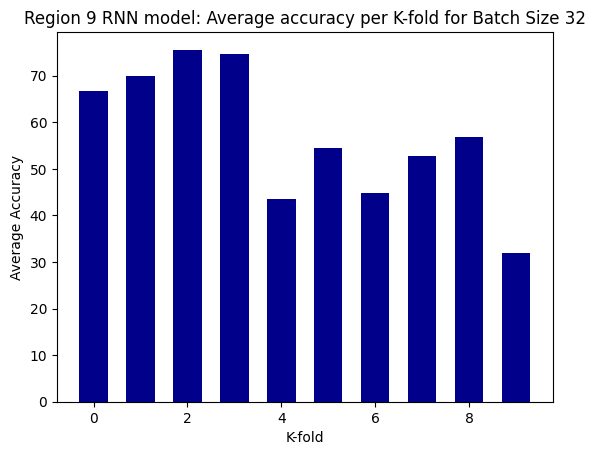

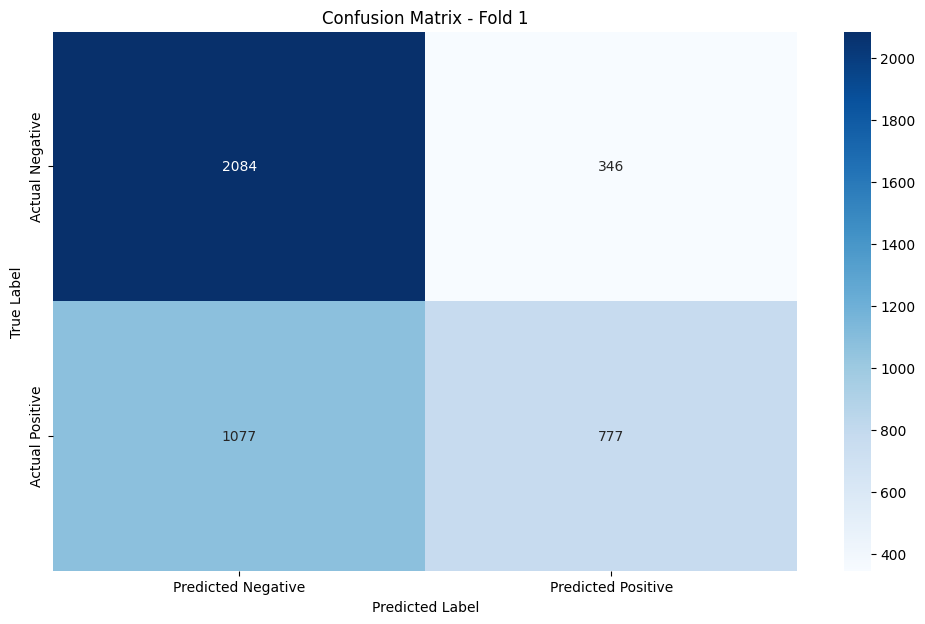

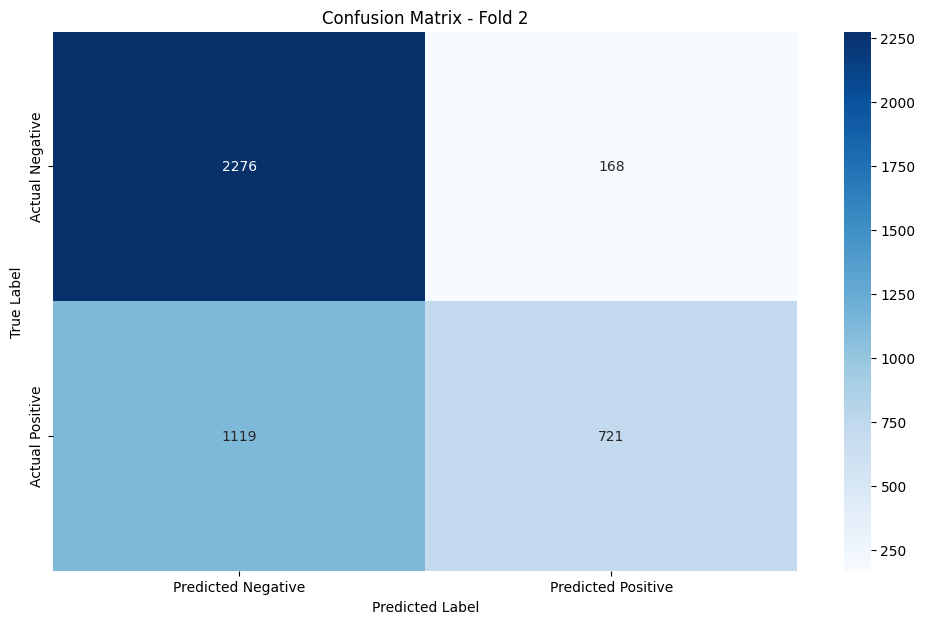

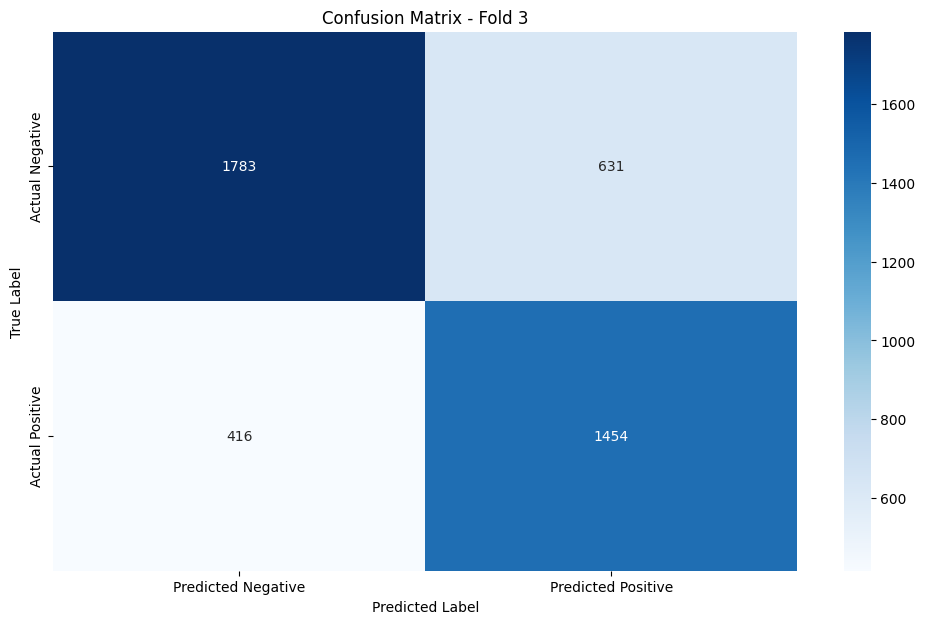

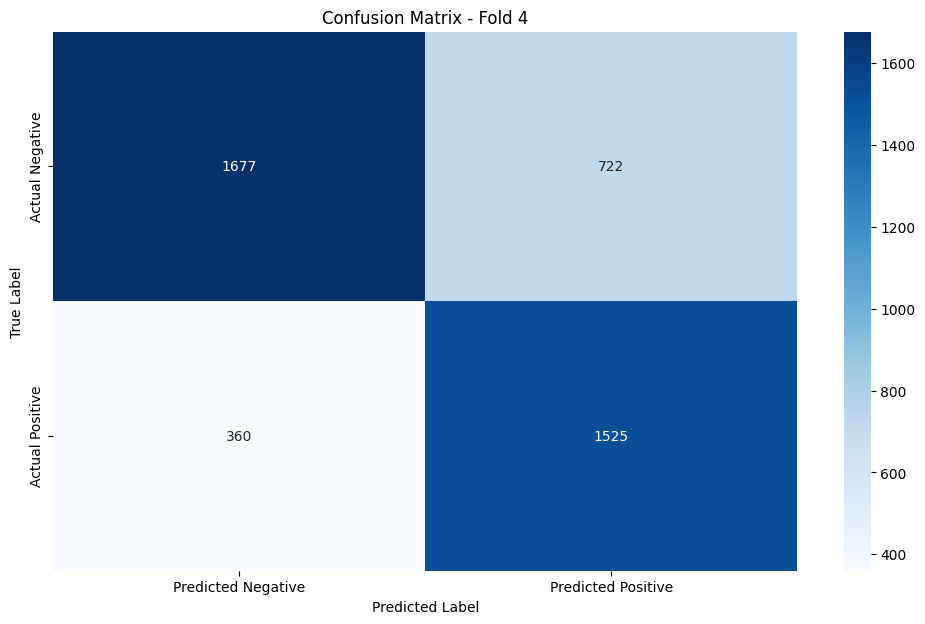

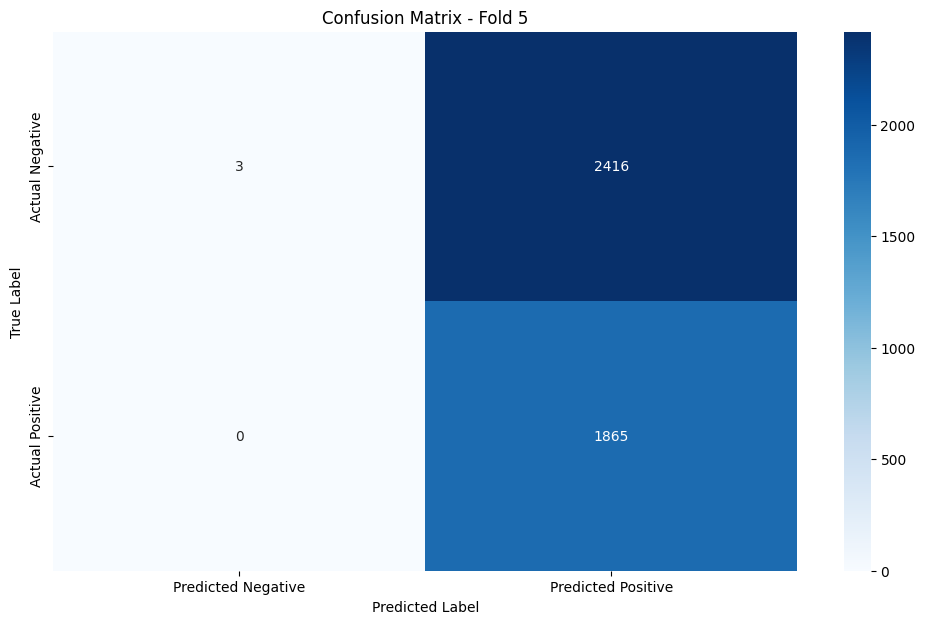

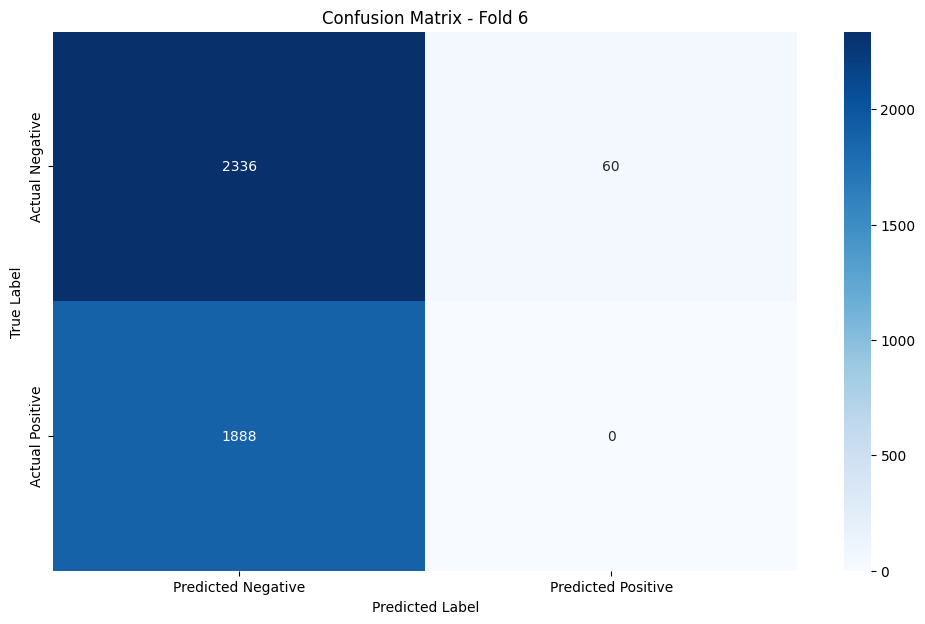

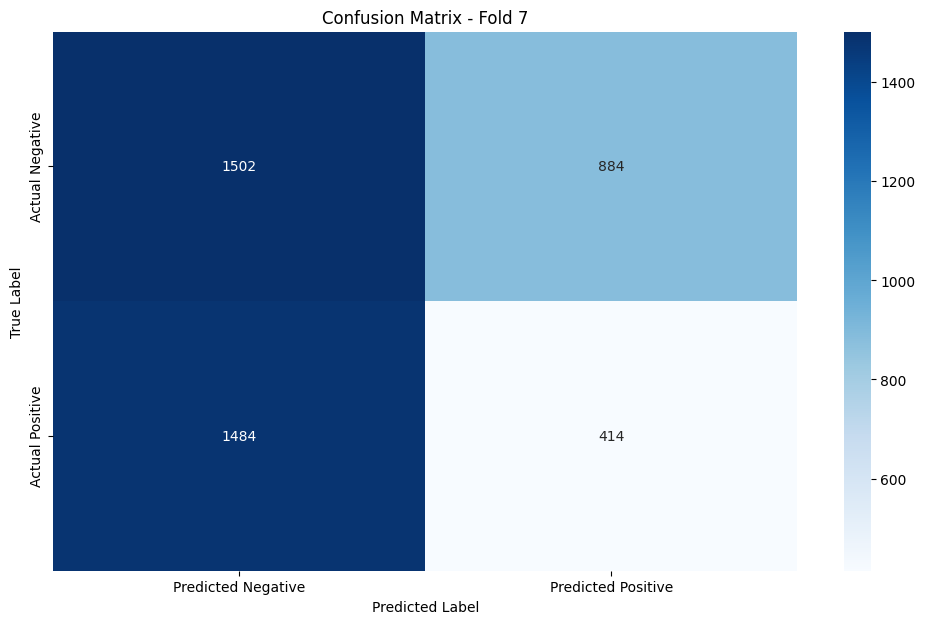

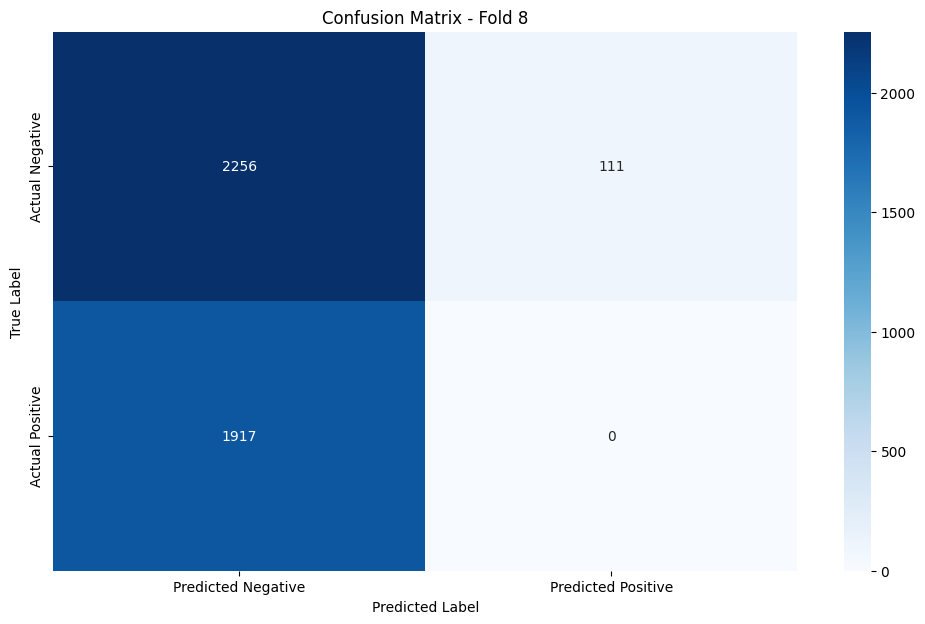

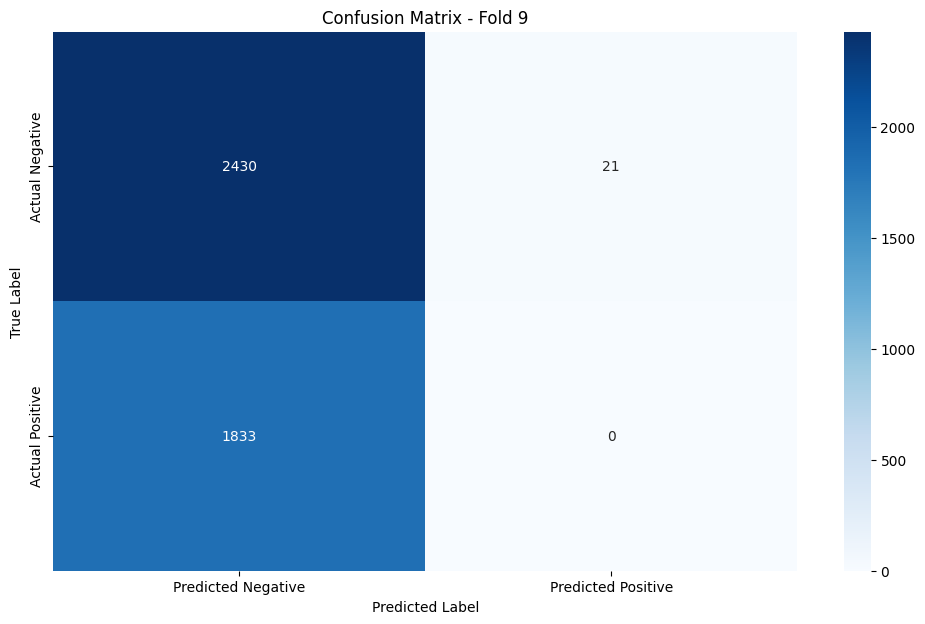

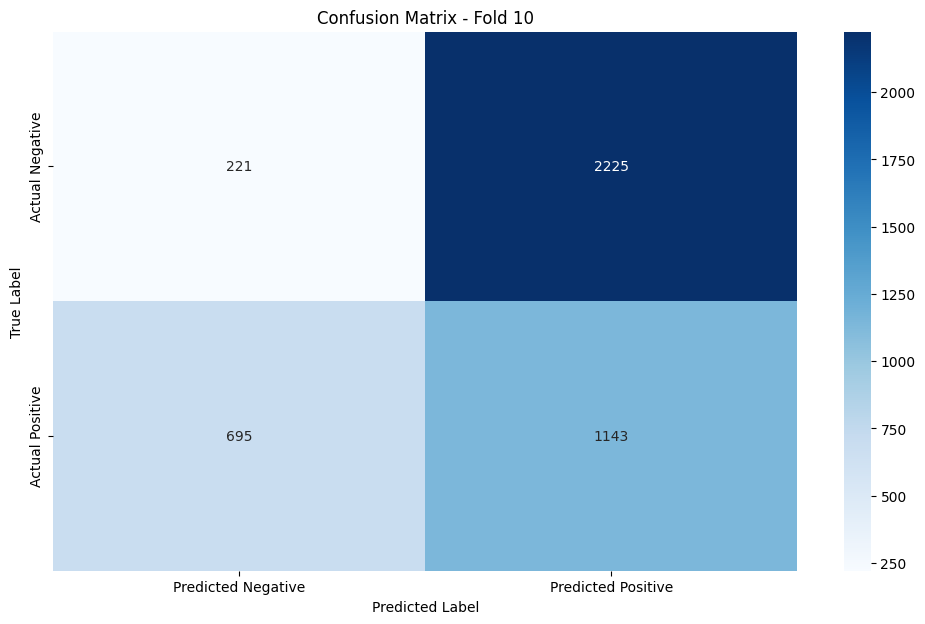

In [42]:
i = 0
for hexlist in best_hexid_per_kfold:
  new_hexlist = []
  for j in hexlist:
    temp = int(j)
    new_hexlist.append(temp)
  best_hexid_per_kfold[i] = new_hexlist
  i +=1

results = pd.DataFrame()
results['pred_y'] = best_all_pred_per_kfold[0][0]
results['actual_y'] = best_all_actual_per_kfold[0][0]
results

# model = NeuralNetwork()
# model.load_state_dict(torch.load("model.pth"))

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
confusion_per_k = []

for k in folds:
  mlcm = multilabel_confusion_matrix(best_actual_in_kfold[k], best_pred_in_kfold[k])
  print(f'=============== K = {k} ================')
  for cm in mlcm:
    tp = cm[0][0]
    tn = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]

    mcc = ((tn * tp) - (fn * fp)) / math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    f1 = tp / (tp + (0.5 * (fp + fn)))

  print(classification_report(best_actual_in_kfold[k], best_pred_in_kfold[k]))
  print('MCC: {}'.format(mcc))
  print('F1: {}'.format(f1))
    # if 0 accuracy is so bad, F1 is how much the predictions are right
    # might need to fix the amount under each label

def Average(lst):
  return sum(lst) / len(lst)

K = folds
# Get the index of the value 30
index_of_best_accuracy = batch_sizes.index(best_batch_size)

avg_accuracy = []
for i in outter_all_test_accuracy[index_of_best_accuracy]:
  avg = Average(i)
  avg_accuracy.append(avg)
print(avg_accuracy)

plt.bar(K, avg_accuracy, color ='darkblue', width = 0.6)
plt.xlabel("K-fold")
plt.ylabel("Average Accuracy")
plt.title(f"Region {region} RNN model: Average accuracy per K-fold for Batch Size {best_batch_size}")
plt.show()

for k in folds:
    cf_matrix = confusion_matrix(best_actual_in_kfold[k], best_pred_in_kfold[k])
    # Plot confusion matrix
    plt.figure(figsize=(12, 7))
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Predicted Negative', 'Predicted Positive'],
               yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'Confusion Matrix - Fold {k+1}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Candidate sites - trained on rg1 data
> This section aims to look for potential optimal locations to put up RHUs. We will call these locations candidate sites. We will use the BP Neural Network that was trained in the section above to find these locations.

#### The results show that there are **3695 candidate sites**. Out of the 7780  locations, we were able to narrow this down to 47% of the Region's LOW ACCESSIBLE AREAS (7780) can have RHUs placed on them.

## Apply model on candidate sites

In [ ]:
# Step 1: Load the saved model
modelpath = "/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/rnn_model.pt" # ⭐👑
candidatenn = RNN(input_size, hidden_size, output_size).to(device)
candidatenn.load_state_dict(torch.load(modelpath))
candidatenn.eval()  # Set the model to evaluation mode

def low_k_fold_splitter(x,y,low_x,low_y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
  # actual labels for testing
  y_test = low_y
  x_train_tensor = torch.tensor(x_train.values, dtype=torch.float)
  x_test_tensor = torch.tensor(low_x.values, dtype=torch.float)
  y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
  y_test_tensor = torch.tensor(low_y.values, dtype=torch.long)

  # Splits X and Y tensors
  train_data = TrainData(x_train_tensor, y_train_tensor)
  test_data = TestData(x_test_tensor, y_test_tensor)

  # Data Loader
  BATCH_SIZE = 20 # ✈️ change this when you run into the [1,256] error :)
  train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(dataset=test_data, batch_size=1)
  return train_loader, test_loader, x_test_tensor, y_test

# global all_train_loss
all_train_loss = []
# global all_test_average_loss_values
all_test_average_loss_values  = []
# global all_test_accuracy
all_test_accuracy = []
# global all_pred_per_kfold
all_pred_per_kfold = []
# global all_actual_per_kfold
all_actual_per_kfold = []
# global actual_in_kfold
actual_in_kfold = []
# global pred_in_kfold
pred_in_kfold = []
# global hexid_per_kfold
hexid_per_kfold = []
best_accuracy = 0.0
modelpatience =20  # Number of epochs with no improvement to wait before stopping

In [ ]:
for k in folds:
  train_loader, test_loader, x_test_tensor, y_test = low_k_fold_splitter(x_normalized, y_sample, filtered_low_accessible_x, filtered_labels_y)
  test_loss_values = []
  test_average_loss_values = []
  test_accuracy_values = []
  counter = 0  # Counter for consecutive epochs with no improvement
  prev_val_loss = float('inf')  # Initialize previous validation loss
  prev_accuracy = 0.0            # Initialize previous accuracy
  epochs = 100 ## change to best epoch pls
  print(f"=================== K = {k+1} ===================\n")

  for epoch in range(epochs):
      train(k,epoch,train_loader, candidatenn, criterion, optimizer)
      val_loss, val_accuracy = test(k,epoch,test_loader, candidatenn, criterion)
      if val_accuracy > best_accuracy:
          best_accuracy = val_accuracy
          counter = 0 # Reset counter if there's improvement
      else:
          counter += 1
      if counter >= modelpatience:
          print(f'No improvement for {modelpatience} consecutive epochs. Stopping early.')
          break

  hidden_state = model.init_zero_hidden(batch_size=x_test_tensor.size(0))
  predictions, _ = model(x_test_tensor, hidden_state)
  predictions = F.softmax(predictions, dim=1)
  predictions = torch.argmax(predictions, dim=1)

  pred_in_kfold.append(predictions)
  actual_y = y_test # actual y values per k-fold
  all_train_loss.append(train_loss_values)# loss
  all_test_average_loss_values.append(test_average_loss_values)# loss
  all_test_accuracy.append(test_accuracy_values) # accuracy
  actual_in_kfold.append(actual_y) # y pred and actual y
  all_pred_per_kfold.append(pred_in_kfold) # y pred and actual y
  all_actual_per_kfold.append(actual_y.tolist()) # y pred and actual y

  print("Done!")

=================== K = 1 ===================

loss: 0.518876  [    0/ 9993]
loss: 0.454345  [ 2000/ 9993]
loss: 0.525687  [ 4000/ 9993]
loss: 0.595988  [ 6000/ 9993]
loss: 0.631223  [ 8000/ 9993]
Fold: 1 | Epoch 1: | Loss: 0.768 | Acc: 37.123
loss: 0.643041  [    0/ 9993]
loss: 0.563167  [ 2000/ 9993]
loss: 0.604071  [ 4000/ 9993]
loss: 0.606607  [ 6000/ 9993]
loss: 0.570970  [ 8000/ 9993]
Fold: 1 | Epoch 2: | Loss: 0.768 | Acc: 37.123
loss: 0.621014  [    0/ 9993]
loss: 0.629775  [ 2000/ 9993]
loss: 0.543262  [ 4000/ 9993]
loss: 0.607821  [ 6000/ 9993]
loss: 0.544099  [ 8000/ 9993]
Fold: 1 | Epoch 3: | Loss: 0.768 | Acc: 37.123
loss: 0.575885  [    0/ 9993]
loss: 0.617269  [ 2000/ 9993]
loss: 0.618909  [ 4000/ 9993]
loss: 0.705879  [ 6000/ 9993]
loss: 0.520126  [ 8000/ 9993]
Fold: 1 | Epoch 4: | Loss: 0.768 | Acc: 37.123
loss: 0.622059  [    0/ 9993]
loss: 0.588887  [ 2000/ 9993]
loss: 0.571685  [ 4000/ 9993]
loss: 0.637495  [ 6000/ 9993]
loss: 0.680039  [ 8000/ 9993]
Fold: 1 | Epoch

## Candidate sites - Results

In [ ]:
# results['hex_id'] = hexid_per_kfold[0]
results = pd.DataFrame()
results['pred_y'] = all_pred_per_kfold[0][0]
results['actual_y'] = all_actual_per_kfold[0][0]

# candidates = pd.concat([results, y_filtered_labels_id], axis=1)
# candidates = candidates.drop(['index'], axis=1)
results[results['pred_y'] == 1]

,pred_y,actual_y
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
7978,1,0
7979,1,0
7980,1,0
7981,1,0


In [ ]:
y_filtered_labels_id

,ID,Cluster
0,3313430,0
1,3314812,0
2,3314813,0
3,3316193,0
4,3316194,0
...,...,...
8981,3504237,0
8982,3505637,0
8983,3507003,0
8984,3518072,0


In [ ]:
# Reset index of both DataFrames
y_filtered_labels_id.reset_index(drop=True, inplace=True)
results.reset_index(drop=True, inplace=True)

# Merge the DataFrames side by side
merged_df = pd.concat([y_filtered_labels_id, results], axis=1)

# Display the merged DataFrame
print(merged_df)

           ID  Cluster  pred_y  actual_y
0     3313430        0       1         0
1     3314812        0       1         0
2     3314813        0       1         0
3     3316193        0       1         0
4     3316194        0       1         0
...       ...      ...     ...       ...
7982  3504237        0       0         0
7983  3505637        0       1         0
7984  3507003        0       0         0
7985  3518072        0       0         0
7986  3519454        0       0         0

[7987 rows x 4 columns]


In [ ]:
candidates = merged_df[merged_df['pred_y'] == 1]
candidate_sites = candidates
len(candidate_sites)

2625

## Export

In [ ]:
all = len(results)
print(all)
buildable = len(candidate_sites)
print(buildable)
build_rhu_landscape = buildable/all
build_rhu_landscape # this tells us how much of the area is a candidate site

7987
2625


0.32865907099035935

In [ ]:
# Export the dataset
save_dir = f"/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG{region}"
# hex_neighbors.to_csv(save_dir + '/Neighbors.csv', index=False)
candidate_sites.to_csv(save_dir + '/candidate_sites.csv', index=False)
filtered_low_accessible_df.to_csv(save_dir + '/PCF_data.csv', index=False)

# Candidate Sites - trained on rg9 data

In [43]:
# Step 1: Load the saved model
modelpath = f"/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG{region}/rnn_model.pt" # ⭐👑
candidatenn = RNN(input_size, hidden_size, output_size, best_batch_size).to(device)
candidatenn.load_state_dict(torch.load(modelpath))
candidatenn.eval()  # Set the model to evaluation mode

def low_k_fold_splitter(x,y,low_x,low_y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
  # actual labels for testing
  y_test = low_y
  x_train_tensor = torch.tensor(x_train.values, dtype=torch.float)
  x_test_tensor = torch.tensor(low_x.values, dtype=torch.float)
  y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
  y_test_tensor = torch.tensor(low_y.values, dtype=torch.long)

  # Splits X and Y tensors
  train_data = TrainData(x_train_tensor, y_train_tensor)
  test_data = TestData(x_test_tensor, y_test_tensor)

  # Data Loader
  BATCH_SIZE = best_batch_size # ✈️ GO BACK TO THIS NEXT SEM - something u can optimize pa
  train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(dataset=test_data, batch_size=1)
  return train_loader, test_loader, x_test_tensor, y_test

# global all_train_loss
all_train_loss = []
# global all_test_average_loss_values
all_test_average_loss_values  = []
# global all_test_accuracy
all_test_accuracy = []
# global all_pred_per_kfold
all_pred_per_kfold = []
# global all_actual_per_kfold
all_actual_per_kfold = []
# global actual_in_kfold
actual_in_kfold = []
# global pred_in_kfold
pred_in_kfold = []
# global hexid_per_kfold
hexid_per_kfold = []
best_accuracy = 0.0
modelpatience =20  # Number of epochs with no improvement to wait before stopping

for k in folds:
  train_loader, test_loader, x_test_tensor, y_test = low_k_fold_splitter(x_normalized, y_sample, filtered_low_accessible_x, filtered_labels_y)
  test_loss_values = []
  test_average_loss_values = []
  test_accuracy_values = []
  counter = 0  # Counter for consecutive epochs with no improvement
  prev_val_loss = float('inf')  # Initialize previous validation loss
  prev_accuracy = 0.0            # Initialize previous accuracy
  epochs = 100 ## change to best epoch pls
  print(f"=================== K = {k+1} ===================\n")

  for epoch in range(epochs):
      train(k,epoch,train_loader, candidatenn, criterion, optimizer)
      val_loss, val_accuracy = test(k,epoch,test_loader, candidatenn, criterion)
      if val_accuracy > best_accuracy:
          best_accuracy = val_accuracy
          counter = 0 # Reset counter if there's improvement
      else:
          counter += 1
      if counter >= modelpatience:
          print(f'No improvement for {modelpatience} consecutive epochs. Stopping early.')
          break

  hidden_state = model.init_zero_hidden(batch_size=x_test_tensor.size(0))
  predictions, _ = model(x_test_tensor, hidden_state)
  predictions = F.softmax(predictions, dim=1)
  predictions = torch.argmax(predictions, dim=1)

  pred_in_kfold.append(predictions)
  actual_y = y_test # actual y values per k-fold
  all_train_loss.append(train_loss_values)# loss
  all_test_average_loss_values.append(test_average_loss_values)# loss
  all_test_accuracy.append(test_accuracy_values) # accuracy
  actual_in_kfold.append(actual_y) # y pred and actual y
  all_pred_per_kfold.append(pred_in_kfold) # y pred and actual y
  all_actual_per_kfold.append(actual_y.tolist()) # y pred and actual y

  print("Done!")

=================== K = 1 ===================

loss: 0.666202  [    0/ 9993]
loss: 0.663224  [ 3200/ 9993]
loss: 0.670585  [ 6400/ 9993]
loss: 0.669024  [ 9600/ 9993]
Fold: 1 | Epoch 1: | Loss: 0.673 | Acc: 73.056
loss: 0.672399  [    0/ 9993]
loss: 0.667572  [ 3200/ 9993]
loss: 0.653873  [ 6400/ 9993]
loss: 0.664649  [ 9600/ 9993]
Fold: 1 | Epoch 2: | Loss: 0.673 | Acc: 73.056
loss: 0.664562  [    0/ 9993]
loss: 0.676863  [ 3200/ 9993]
loss: 0.668724  [ 6400/ 9993]
loss: 0.652787  [ 9600/ 9993]
Fold: 1 | Epoch 3: | Loss: 0.673 | Acc: 73.056
loss: 0.672533  [    0/ 9993]
loss: 0.669377  [ 3200/ 9993]
loss: 0.658470  [ 6400/ 9993]
loss: 0.665909  [ 9600/ 9993]
Fold: 1 | Epoch 4: | Loss: 0.673 | Acc: 73.056
loss: 0.670049  [    0/ 9993]
loss: 0.675133  [ 3200/ 9993]
loss: 0.664401  [ 6400/ 9993]
loss: 0.667309  [ 9600/ 9993]
Fold: 1 | Epoch 5: | Loss: 0.673 | Acc: 73.056
loss: 0.671165  [    0/ 9993]
loss: 0.664386  [ 3200/ 9993]
loss: 0.666127  [ 6400/ 9993]
loss: 0.666538  [ 9600/ 9993

In [44]:
# results['hex_id'] = hexid_per_kfold[0]
results = pd.DataFrame()
results['pred_y'] = all_pred_per_kfold[0][0]
results['actual_y'] = all_actual_per_kfold[0][0]

# candidates = pd.concat([results, y_filtered_labels_id], axis=1)
# candidates = candidates.drop(['index'], axis=1)
print(results[results['pred_y'] == 1])
print(y_filtered_labels_id)

# Reset index of both DataFrames
y_filtered_labels_id.reset_index(drop=True, inplace=True)
results.reset_index(drop=True, inplace=True)

# Merge the DataFrames side by side
merged_df = pd.concat([y_filtered_labels_id, results], axis=1)

# Display the merged DataFrame
print(merged_df)

candidates = merged_df[merged_df['pred_y'] == 1]
candidate_sites = candidates
len(candidate_sites)

all = len(results)
print(all)
buildable = len(candidate_sites)
print(buildable)
build_rhu_landscape = buildable/all
print(build_rhu_landscape) # this tells us how much of the area is a candidate site

# Export the dataset
save_dir = f"/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG{region}"
# hex_neighbors.to_csv(save_dir + '/Neighbors.csv', index=False)
candidate_sites.to_csv(save_dir + '/candidate_sites.csv', index=False)
filtered_low_accessible_df.to_csv(save_dir + '/PCF_data.csv', index=False)

      pred_y  actual_y
0          1         0
2          1         0
3          1         0
5          1         0
6          1         0
...      ...       ...
7981       1         0
7983       1         0
7984       1         0
7985       1         0
7986       1         0

[6026 rows x 2 columns]
           ID  Cluster
0     3313430        0
1     3314812        0
2     3314813        0
3     3316193        0
4     3316194        0
...       ...      ...
8981  3504237        0
8982  3505637        0
8983  3507003        0
8984  3518072        0
8985  3519454        0

[7987 rows x 2 columns]
           ID  Cluster  pred_y  actual_y
0     3313430        0       1         0
1     3314812        0       0         0
2     3314813        0       1         0
3     3316193        0       1         0
4     3316194        0       0         0
...       ...      ...     ...       ...
7982  3504237        0       0         0
7983  3505637        0       1         0
7984  3507003        0       

# PCF calculations
**Goal:** Get the buildable areas with their populations

**Remember, we want to target areas with HIGH POPULATION and LIMITED to NO RHU ACCESS!**

#### ***Recommended number of facilities is 1 for Region 8.***
dont forget you will be using this value in optimize-2 when you get the optimal number of facilities


In [ ]:
# rg1n_clustered_df.drop(rg1n_clustered_df.index[rg1n_clustered_df['Cluster'] == 1], inplace = True)
# rg1n_clustered_df.drop(rg1n_clustered_df.index[rg1n_clustered_df['popden_all'] == 0], inplace = True)

hex_with_rhu = rg1n_clustered_df[rg1n_clustered_df['RHU_Presence'] == 1]
hex_with_rhu
buildable = rg1n_clustered_df[rg1n_clustered_df['buildability_landcov'] == 1]
buildable
non_buildable.shape # (5292, 23)
buildable.shape # (2216, 24)

(5970, 23)

In [ ]:
high_clustered = buildable[buildable['Cluster'] == 1]
high_clustered[high_clustered['buildability_landcov'] == 1] # look for buildable areas in high clustered areas
high_clustered[high_clustered['buildability_landcov'] == 0] # look for non buildable areas in high clustered areas
high_clustered['buildability_landcov'].unique() # looking for unique values. If its one, all places in this df are buiildable for RHUs

# df with RHUs + df with buildable areas == SABLAYAN
# using this to compute for the total population
frames = [hex_with_rhu, rg1n_clustered_df]
rg1_PCF_df = pd.concat(frames)
rg1_PCF_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster,total_population
36,36,3330011,Poblacion Barangay 2,Capul,Northern Samar,1.121741,1.461005,0.531970,0,1,...,0.000000,125.622044,198.256795,1450.526487,746.770031,334.267201,255.273099,0.469500,0,1450.526487
298,298,3353597,Guiwan 1 (Pob.),Palompon,Leyte,1.474404,1.733066,0.855013,0,1,...,0.000000,776.290804,842.036758,8030.162304,4063.355687,2070.823705,1539.804809,0.418218,0,8030.162304
729,729,3363171,Barangay North (Pob.),San Jose,Northern Samar,1.583639,1.795818,0.685848,0,1,...,0.000000,195.716123,88.762457,1443.303291,698.825705,323.049642,259.419765,0.506698,0,1443.303291
1132,1132,3370082,Salvacion,Bobon,Northern Samar,1.553320,1.784341,0.734574,0,1,...,0.000000,829.887023,538.350229,7443.771018,3797.620692,1787.976131,1438.971850,0.429498,0,7443.771018
1525,1525,3377093,Barangay 3 (Pob.),Ormoc City,Leyte,1.076424,1.840858,0.927464,0,1,...,0.000000,2313.223762,1435.531282,21533.182405,10979.592565,5894.718151,4397.918610,0.438031,0,21533.182405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8981,8981,3504237,Ngolos,Guiuan,Eastern Samar,3.142842,1.754262,0.584311,0,0,...,46.986907,0.984148,0.680468,7.912546,3.801621,1.782713,1.366559,0.392827,0,7.912546
8982,8982,3505637,Cagusu-an,Guiuan,Eastern Samar,2.160672,1.754547,0.564089,0,0,...,62.553435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
8983,8983,3507003,Sulangan,Guiuan,Eastern Samar,3.232944,1.746120,0.587511,0,0,...,50.731541,118.603833,84.144597,999.317445,505.669059,212.364957,147.453414,0.461363,0,999.317445
8984,8984,3518072,Suluan,Guiuan,Eastern Samar,2.965111,1.737982,0.569467,0,0,...,70.953292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000


In [ ]:
rg1_PCF_df.reset_index(drop=True, inplace=True)
rg1_PCF_df.drop(columns=['Unnamed: 0'], inplace=True)
total_rgn1_population = 0
def PCF(total_population):
  PCF = total_population / 20000
  return int(PCF)

In [ ]:
a = 1.65 # or 13042??
pd = rg1_PCF_df['popden_all']
rg1_PCF_df['total_population'] = pd * a
rg1_PCF_df

,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,Road_Presence,...,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster,total_population
0,3330011,Poblacion Barangay 2,Capul,Northern Samar,1.121741,1.461005,0.531970,0,1,0,...,0.000000,125.622044,198.256795,1450.526487,746.770031,334.267201,255.273099,0.469500,0,2393.368704
1,3353597,Guiwan 1 (Pob.),Palompon,Leyte,1.474404,1.733066,0.855013,0,1,0,...,0.000000,776.290804,842.036758,8030.162304,4063.355687,2070.823705,1539.804809,0.418218,0,13249.767802
2,3363171,Barangay North (Pob.),San Jose,Northern Samar,1.583639,1.795818,0.685848,0,1,1,...,0.000000,195.716123,88.762457,1443.303291,698.825705,323.049642,259.419765,0.506698,0,2381.450430
3,3370082,Salvacion,Bobon,Northern Samar,1.553320,1.784341,0.734574,0,1,0,...,0.000000,829.887023,538.350229,7443.771018,3797.620692,1787.976131,1438.971850,0.429498,0,12282.222180
4,3377093,Barangay 3 (Pob.),Ormoc City,Leyte,1.076424,1.840858,0.927464,0,1,0,...,0.000000,2313.223762,1435.531282,21533.182405,10979.592565,5894.718151,4397.918610,0.438031,0,35529.750968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9013,3504237,Ngolos,Guiuan,Eastern Samar,3.142842,1.754262,0.584311,0,0,0,...,46.986907,0.984148,0.680468,7.912546,3.801621,1.782713,1.366559,0.392827,0,13.055701
9014,3505637,Cagusu-an,Guiuan,Eastern Samar,2.160672,1.754547,0.564089,0,0,0,...,62.553435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
9015,3507003,Sulangan,Guiuan,Eastern Samar,3.232944,1.746120,0.587511,0,0,0,...,50.731541,118.603833,84.144597,999.317445,505.669059,212.364957,147.453414,0.461363,0,1648.873784
9016,3518072,Suluan,Guiuan,Eastern Samar,2.965111,1.737982,0.569467,0,0,0,...,70.953292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000


In [ ]:
rg1_PCF_df.columns
total_rgn1_population = rg1_PCF_df['total_population'].sum()
# total_rgn1_population = rg1_PCF_df['popden_all'].sum()
print(round(total_rgn1_population, 2))
print(PCF(total_rgn1_population))

7024704.94
351
